In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import datetime
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE
from tensorflow.python.data import Dataset

from deepcell import losses
from deepcell import image_generators
from deepcell.utils import train_utils
from deepcell.utils import tracking_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.utils.train_utils import get_callbacks


In [2]:
# copied from Intro notebook
import deepcell

base_url = ('https://deepcell-data.s3-us-west-1.amazonaws.com/'
            'demos/janelia/hela_s3_{}_256.npz')

nuclear = deepcell.datasets.Dataset(
    path='nuclear.npz',
    url=base_url.format('nuclear'),
    file_hash='04a200f437aa2f7c66d636c84c379ba7',
    metadata=None
)

fluo_cyto = deepcell.datasets.Dataset(
    path='fluo_cyto.npz',
    url=base_url.format('fluo_cyto'),
    file_hash='6a8a3ba4ddf3de8bb90776fa41a5a664',
    metadata=None
)

phase = deepcell.datasets.Dataset(
    path='phase.npz',
    url=base_url.format('phase'),
    file_hash='c56df51039fe6cae15c818118dfb8ce8',
    metadata=None
)

In [3]:
MODEL_PATH = ('https://deepcell-data.s3-us-west-1.amazonaws.com/'
              'saved-models/NuclearSegmentation-5.tar.gz')
MODEL_HASH = 'c3667ffbe08035c9cb69ed882e4a49d7'
archive_path = tf.keras.utils.get_file(
                'NuclearSegmentation.tgz', MODEL_PATH,
                file_hash=MODEL_HASH,
                extract=True, cache_subdir='models'
            )
model_path = os.path.splitext(archive_path)[0]
print(model_path)
model = tf.keras.models.load_model(model_path)

/home/yfong/.keras/models/NuclearSegmentation


2022-10-21 16:55:34.170094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10429 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:5e:00.0, compute capability: 6.1


In [4]:
is_channels_first = K.image_data_format() == 'channels_first'
print(K.image_data_format())
n_classes = model.layers[-1].output_shape[1 if is_channels_first else -1]
n_classes

channels_last


1

(7, 1040, 1159, 1)


/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


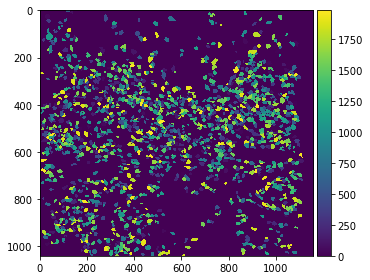

(7, 1040, 1159, 1)


In [8]:
# Import images
import glob
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline

imgfiles = glob.glob('*_img.png')
img=io.imread(imgfiles[0])
(img.shape)
im=img[:,:,0]
#io.imshow(im)
#plt.show()

imgs = [io.imread(imgfile)[:,:,0] for imgfile in imgfiles]
(imgs[0].shape)

X_train = tf.stack(imgs)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

# read mask files

maskfiles = glob.glob('*_masks.png')
img=io.imread(maskfiles[0])
(img.shape)
im=img
io.imshow(im)
plt.show()

masks = [io.imread(imgfile) for imgfile in maskfiles]
(masks[0].shape)

y_train = tf.stack(masks)
y_train = np.expand_dims(y_train, axis=-1)
print(y_train.shape)

#
X=X_train
y=y_train
np.savez("K_training_data", X=X, y=y) # objects to save need to be key value pairs

#y_train = cv2.imread('/home/shan/kdata/M872956_Position8_CD3-BUV395_no_inputs_GTmasks_1908_masks.png', cv2.IMREAD_UNCHANGED)
#y_train = y_train.reshape((1, y_train.shape[0], y_train.shape[1], 1))


In [9]:
test_size=.2
seed=0
train_dict, test_dict = get_data("K_training_data.npz", test_size=test_size, seed=seed)

In [10]:
def loss_function(y_true, y_pred):
    if isinstance(transform, str) and transform.lower() == 'disc':
        return losses.discriminative_instance_loss(y_true, y_pred)
    if focal:
        return losses.weighted_focal_loss(
            y_true, y_pred, gamma=gamma, n_classes=n_classes)
    return losses.weighted_categorical_crossentropy(
        y_true, y_pred, n_classes=n_classes)


In [17]:
def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [18]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler
num_gpus = train_utils.count_gpus()
n_epoch = 100
optimizer = Adam(lr=1e-4, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-4, decay=0.99)
batch_size = 8
min_objects = 0  # throw out images with fewer than this many objects
seed=0
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'], run_eagerly=True)


2022-10-09 18:06:25.783474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 10429 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:5e:00.0, compute capability: 6.1


In [21]:
# copied from deepcell/training.py
window_size=(224, 224)
if train_dict['X'].ndim == 4:
    DataGenerator = image_generators.SampleDataGenerator
    window_size = window_size if window_size else (30, 30)
elif train_dict['X'].ndim == 5:
    DataGenerator = image_generators.SampleMovieDataGenerator
    window_size = window_size if window_size else (30, 30, 3)
else:
    raise ValueError('Expected `X` to have ndim 4 or 5. Got',
                     train_dict['X'].ndim)
    
rotation_range=180
shear_range=0
zoom_range=(0.7, 1/0.7)
horizontal_flip=True
vertical_flip=True
datagen = DataGenerator(
        rotation_range=rotation_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip)
datagen_val = DataGenerator(
        rotation_range=0,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=0,
        vertical_flip=0)

In [24]:
# copied from Intro notebook
transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator()
    
train_data = datagen.flow(
    train_dict,
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    test_dict,
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

In [13]:
# copied from deepcell_cyto_train.py
datagen = image_generators.CroppingDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.7, 1/0.7),
    horizontal_flip=True,
    vertical_flip=True,
    crop_size=(256, 256))

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)


In [25]:
balance_classes=False
max_class_samples=None

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}

train_data = datagen.flow(
    train_dict,
    seed=seed,
    batch_size=batch_size,
    transforms=transforms, 
    transforms_kwargs=transforms_kwargs,
    #transforms=['outer-distance'], transforms_kwargs=None,
    min_objects=min_objects)

val_data = datagen_val.flow(
    test_dict,
    seed=seed,
    batch_size=batch_size,
    transforms=transforms, 
    transforms_kwargs=transforms_kwargs,
    #transforms=['outer-distance'], transforms_kwargs=None,
    min_objects=min_objects)
    

username = os.getlogin()
log_dir = os.path.join('logs')
train_callbacks = get_callbacks(
        model_path, lr_sched=lr_sched,
        tensorboard_log_dir=log_dir,
        save_weights_only=num_gpus >= 2,
        monitor='val_loss', verbose=1)

In [26]:
loss_history = model.fit(
        train_data,
        steps_per_epoch=train_data.y.shape[0] // batch_size,
        epochs=n_epoch,
        validation_data=val_data,
        validation_steps=val_data.y.shape[0] // batch_size,
        callbacks=train_callbacks)


Epoch 1/100


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [28]:
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context

In [38]:
# copied from training_mesmer.py
# Training model
# One-channel (CD3)
import tensorflow as tf
MODEL_PATH = ('https://deepcell-data.s3-us-west-1.amazonaws.com/saved-models/CytoplasmSegmentation-3.tar.gz')
MODEL_HASH = '6a244f561b4d37169cb1a58b6029910f'
archive_path = tf.keras.utils.get_file(
                'CytoplasmSegmentation.tgz', MODEL_PATH,
                file_hash=MODEL_HASH,
                extract=True, cache_subdir='models')
model_path = os.path.splitext(archive_path)[0]
old_model = tf.keras.models.load_model(model_path)
new_model = old_model
#new_model.save_weights('/home/shan/cyto_pretrained_weights.h5')


from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = '20221009'
n_epoch = 100
optimizer = Adam(learning_rate=1e-4, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-4, decay=0.99)
batch_size = 1 # 8
min_objects = 0  # throw out images with fewer than this many objects
seed=0
model_name


# Define data generators
from deepcell import image_generators
from deepcell.utils import train_utils

datagen = image_generators.CroppingDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.7, 1/0.7),
    horizontal_flip=True,
    vertical_flip=True,
    #crop_size=(256, 256)) # generate error
    crop_size=(512, 512))

#datagen_val = image_generators.SemanticDataGenerator(
#    rotation_range=0,
#    shear_range=0,
#    zoom_range=0,
#    horizontal_flip=0,
#    vertical_flip=0)
    
train_data = datagen.flow(
    train_dict,
    seed=seed,
    transforms=['inner-distance','pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    test_dict,
    seed=seed,
    transforms=['inner-distance', 'pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1},
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)


# Define loss (create a dictionary of losses for each semantic head)
from tensorflow.python.keras.losses import MSE
from deepcell import losses

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in new_model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

new_model.compile(loss=loss, optimizer=optimizer)


# Iterate model training 
from timeit import default_timer
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus



A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6a244f561b4d37169cb1a58b6029910f so we will re-download the data.
95272960/95263450 [==============================] - 28s 0us/step


In [30]:
MODEL_DIR = os.path.join('models')
LOG_DIR = os.path.join('logs')

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

#num_gpus = count_gpus()
#print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=True,
    #save_weights_only=num_gpus >= 2,
    #monitor='val_loss',
    monitor='loss', # training loss
    verbose=1)

start = default_timer()
loss_history = new_model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    #validation_data=val_data,
    #validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)
training_time = default_timer() - start
print('Training time: ', training_time, 'seconds.')


/tmp/ipykernel_61146/1164638064.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = new_model.fit_generator(
/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/morphology/misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0.Please use `footprint` instead.
  return func(image, footprint=footprint, *args, **kwargs)


Epoch 1/100


2022-10-09 18:27:05.438660: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


5/5 [==============================] - ETA: 0s - loss: 0.3159 - semantic_0_loss: 0.0394 - semantic_1_loss: 0.2765
Epoch 00001: loss improved from inf to 0.31588, saving model to models/20221009.h5
5/5 [==============================] - 55s 502ms/step - loss: 0.3159 - semantic_0_loss: 0.0394 - semantic_1_loss: 0.2765 - lr: 1.0000e-04
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.2792 - semantic_0_loss: 0.0300 - semantic_1_loss: 0.2491
Epoch 00002: loss improved from 0.31588 to 0.27915, saving model to models/20221009.h5
5/5 [==============================] - 3s 584ms/step - loss: 0.2792 - semantic_0_loss: 0.0300 - semantic_1_loss: 0.2491 - lr: 9.9000e-05
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.2741 - semantic_0_loss: 0.0302 - semantic_1_loss: 0.2439
Epoch 00003: loss improved from 0.27915 to 0.27412, saving model to models/20221009.h5
5/5 [==============================] - 3s 643ms/step - loss: 0.2741 - semantic_0_loss: 0.0302 - semant

5/5 [==============================] - ETA: 0s - loss: 0.2591 - semantic_0_loss: 0.0348 - semantic_1_loss: 0.2243
Epoch 00026: loss did not improve from 0.24715
5/5 [==============================] - 3s 442ms/step - loss: 0.2591 - semantic_0_loss: 0.0348 - semantic_1_loss: 0.2243 - lr: 7.7782e-05
Epoch 27/100
5/5 [==============================] - ETA: 0s - loss: 0.2538 - semantic_0_loss: 0.0296 - semantic_1_loss: 0.2241
Epoch 00027: loss did not improve from 0.24715
5/5 [==============================] - 2s 445ms/step - loss: 0.2538 - semantic_0_loss: 0.0296 - semantic_1_loss: 0.2241 - lr: 7.7004e-05
Epoch 28/100
5/5 [==============================] - ETA: 0s - loss: 0.2460 - semantic_0_loss: 0.0219 - semantic_1_loss: 0.2241
Epoch 00028: loss improved from 0.24715 to 0.24605, saving model to models/20221009.h5
5/5 [==============================] - 3s 618ms/step - loss: 0.2460 - semantic_0_loss: 0.0219 - semantic_1_loss: 0.2241 - lr: 7.6234e-05
Epoch 29/100
5/5 [======================

5/5 [==============================] - ETA: 0s - loss: 0.2516 - semantic_0_loss: 0.0284 - semantic_1_loss: 0.2232
Epoch 00052: loss did not improve from 0.24475
5/5 [==============================] - 2s 458ms/step - loss: 0.2516 - semantic_0_loss: 0.0284 - semantic_1_loss: 0.2232 - lr: 5.9896e-05
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.2518 - semantic_0_loss: 0.0283 - semantic_1_loss: 0.2235
Epoch 00053: loss did not improve from 0.24475
5/5 [==============================] - 2s 456ms/step - loss: 0.2518 - semantic_0_loss: 0.0283 - semantic_1_loss: 0.2235 - lr: 5.9297e-05
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.2476 - semantic_0_loss: 0.0240 - semantic_1_loss: 0.2237
Epoch 00054: loss did not improve from 0.24475
5/5 [==============================] - 2s 418ms/step - loss: 0.2476 - semantic_0_loss: 0.0240 - semantic_1_loss: 0.2237 - lr: 5.8704e-05
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.2498 - sem

(1040, 233)


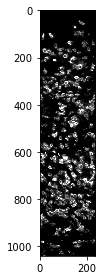

(1040, 233)


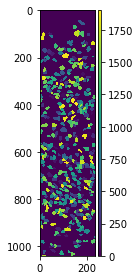

NameError: name 'CytoplasmSegmentation' is not defined

In [34]:
from skimage import io

im0 = io.imread('../test/M872956_JML_Position8_CD3_test_img.png')
print(im0.shape)
im=im0
io.imshow(im)
plt.show()
im = np.expand_dims(im, axis=-1)
im = np.expand_dims(im, axis=0)

mask_true=io.imread("../test/M872956_JML_Position8_CD3_test_masks.png")
print(mask_true.shape)
io.imshow(mask_true)
plt.show()



In [35]:
from deepcell.applications import NuclearSegmentation
from deepcell.applications import CytoplasmSegmentation

In [39]:
app = CytoplasmSegmentation(old_model)

(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}


/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


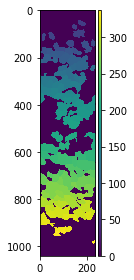

0.05343511450381679

In [40]:
import syotil

x=im
y, tile_info = app._tile_input(x)
print(x.shape)
print(y.shape)
print(tile_info)
pred = app.predict(y, image_mpp=1) 
prd = app._untile_output(pred, tile_info)
io.imshow(prd[0,:,:,0])
plt.show()
syotil.csi(mask_true, prd[0,:,:,0])# 0.21 without passing image_mpp. Setting image_mpp to 1 improves to 0.37